In [1]:
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from scipy.interpolate import splprep, splev


np.set_printoptions(suppress=True)
np.random.seed(2022)
%load_ext autoreload
%autoreload 2

### Load dataset

In [2]:
def load_toy_frames(folder="../../odometry/toy-data/dataset_images_matlab"):
    
    frames = []
    
    for file in sorted(os.listdir(folder)):
        
        if ".png" in file:
            
            fpath = os.path.join(folder, file)
            
            img = cv2.imread(fpath)
            
            frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return frames

In [3]:
def load_frames(video_folder, start_time, end_time):
    """ Load frames from the folder with specified start_time & end_time in seconds


    Inputs:
        video_folder: [str], the folder containing video.mp4, folder for frames, txt file for frame rate
        start_time, end_time: [int] in second

    Parameters
    ----------
    video_folder : [str]
        the folder where the video's 'frames' subfolder is
    start_time : [int]
        the start time to load
    end_time : [int]
        the end time to load

    Returns
    -------
    frames : [list[np.ndarray]]
        a list of loaded frames
    fps : [float]
        the original frames per second of the video
    """
    
    # get frame rate
    fr_file = os.path.join(video_folder, 'fps.txt')
    
    fps = None
    
    with open(fr_file, 'r') as f:
    
        fps = float(f.read())
        
        print(f'Video - {video_folder.split("/")[-1]} - fps: {fps}')
    
    # no fps.txt in the folder => probably haven't exported yet
    if not fps:
        raise ValueError('No fps is found!')
    
    start_fr = int(start_time * fps)
    end_fr = int(end_time * fps)
    
    frames = []
    
    print(f'loading video frames from {start_fr} to {end_fr}')
    
    for i_frame in tqdm(range(start_fr, end_fr)):
        
        frame_path = os.path.join(video_folder, 'frames', f'frame_{i_frame}.jpg')
        
        img = cv2.imread(frame_path)

        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return frames, fps

In [4]:
# load real video frames
frames, fps = load_frames("../../odometry/demo-video-frames/portland-me_20210818_41_corey", 15, 80)

Video - portland-me_20210818_41_corey - fps: 20.000982999884354
loading video frames from 300 to 1600


  0%|          | 0/1300 [00:00<?, ?it/s]

In [5]:
# # load toy dataset
# frames = load_toy_frames()
# frames = frames 


### Camera Intrinsics (K)

In [6]:
# real video - camera intrinsics
K = np.array([[1304.728954148559, 0.0, 946.9610479577617], 
              [0.0, 1304.2418122900801, 535.7368433856345], 
              [0.0, 0.0, 1.0]])

In [7]:
# # toy data - camera intrinsics
# K = np.array([[615, 0, 320], 
#               [0.0, 615, 240], 
#               [0.0, 0.0, 1.0]])


### Monocular Visual Odometry

In [9]:
class MonocularVisualOdometry:
    
    def __init__(self, 
                 frame_height, 
                 frame_width,
                 K,
                 num_orb_features=2000,
                 max_disp_to_track=5,
                 min_num_kps_to_track=500,
                 init_min_angle_to_triangulate=2,
                 init_max_angle_to_triangulate=40,
                 track_min_angle_to_triangulate=0.5,
                 track_max_angle_to_triangulate=80,
                 track_window_size=(5, 5)):
        
        # intrinsics
        self.K = K
        
        self.focal = (self.K[0, 0] + self.K[1, 1]) / 2
        
        # (cx, cy)
        self.cxy = (self.K[0, 2], self.K[1, 2])
        
        # image (frame) height & width
        self.height = frame_height
        self.width = frame_width
        
        # init feature detector & params
        
        # FAST vs. ORB: FAST seems to make the result smoothier (feature points are more stable)
        self.detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
        
        # self.num_orb_features = num_orb_features
        # self.detector = cv2.ORB_create(self.num_orb_features)
    
        # init feature tracker & params
        self.min_num_kps_to_track = min_num_kps_to_track
        
        self.track_window_size = track_window_size
        
        self.max_disp_to_track = max_disp_to_track
        
        self.lk_params = dict(winSize=self.track_window_size, 
                              criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.001))
        
    
        # triangulate criteria
        self.init_min_angle_to_triangulate = init_min_angle_to_triangulate
        self.init_max_angle_to_triangulate = init_max_angle_to_triangulate
        self.track_min_angle_to_triangulate = track_min_angle_to_triangulate
        self.track_max_angle_to_triangulate = track_max_angle_to_triangulate

                
        # map / graph collection (R, T, 3D points)
    
    def detect_kps(self, frame):
        """Detect keypoints in a frame with FAST feature detector

        Parameters
        ----------
        frame : [np.ndarray]
            the frame to be processed

        Returns
        -------
        kps :  [np.ndarray], shape (N, 2), N: number of 2D points
            the detected keypoints in the frame. 
        """
        
        # frame
        # kps, _ = self.detector.detectAndCompute(frame, None)
        
        kps = self.detector.detect(frame)
        
        # kps = self.select_uniform_kps(kps)
        
        # convert cv2.KeyPoint to (x, y)
        kps = np.array([k.pt for k in kps])

        return kps
    
    def select_uniform_kps(self, kps, grid_size=32, n_at_most=30):
        """
        Make feature points uniformly distributed in the image
        """

        grid = np.zeros((grid_size, grid_size))

        ws = self.width // grid_size
        hs = self.height // grid_size

        sorted_kps = sorted(kps, key=lambda x: x.response)

        selected_kps = []

        for k in sorted_kps:

            # x
            ix = int(k.pt[0] // ws)

            # y
            iy = int(k.pt[1] // hs)

            if grid[iy, ix] <= n_at_most:
                selected_kps.append(k)
                grid[iy, ix] += 1

        return selected_kps 

    def track_kps(self, last_frame, last_kps, curr_frame):
        """Track the keypoints using the Lucas-Kanade method

        Parameters
        ----------
        last_frame : [np.ndarray]
        last_kps : [np.ndarray], shape (N, 2)
        curr_frame : [np.ndarray]

        Returns
        -------
        curr_kps : [np.ndarray], shape (N, 2)
        """
        
        valid_idx = ~np.isnan(last_kps[:, 0])
        
        valid_curr_kps, st, err = cv2.calcOpticalFlowPyrLK(last_frame, 
                                                           curr_frame, 
                                                           last_kps[valid_idx].astype(np.float32), 
                                                           None, 
                                                           **self.lk_params)
        
        # verification - 1 : error should be within the range
        st[(err > self.max_disp_to_track).squeeze()] = 0
        
        # verification - 2 : coordinate boundary [0, self.height - 1], [0, self.width - 1]
        st[(valid_curr_kps[:, 0] <= 0) | (valid_curr_kps[:, 1] <= 0)] = 0
        st[(valid_curr_kps[:, 0] >= self.width) | (valid_curr_kps[:, 1] >= self.height)] = 0
        
        # create the mask 
        # => value 1: the ones should be masked out (large error or beyond the boundary)
        mask = (st == 0).squeeze()
        
        valid_curr_kps[mask] = np.nan
        
        curr_kps = np.ones_like(last_kps) * np.nan
        
        curr_kps[valid_idx] = valid_curr_kps

        return curr_kps
            
    def estimate_pose(self, last_kps, curr_kps):
        """Estimate the camera pose with epipolar geometry

        Parameters
        ----------
        last_kps : [np.ndarray], shape (N, 2)
        curr_kps : [np.ndarray], shape (N, 2)
        
        Returns
        -------
        R : [np.ndarray], shape (3, 3)
        T : [np.ndarray], shape (3, 1)
        all_inliers : [np.ndarray], shape (N,)
        """
        
        valid_idx = ~np.isnan(curr_kps[:, 0])
            
        # note: 
        # mask : 0 & 255
        E, mask = cv2.findEssentialMat(last_kps[valid_idx],
                                       curr_kps[valid_idx],
                                       pp=self.cxy, 
                                       focal=self.focal, 
                                       method=cv2.RANSAC, 
                                       prob=0.999, 
                                       threshold=1.0)

        
        # get the camera pose (of current frame)
        # inliers: 0 & 1
        _, R, T, inliers = cv2.recoverPose(E, 
                                           last_kps[valid_idx], 
                                           curr_kps[valid_idx], 
                                           focal=self.focal, 
                                           pp=self.cxy) 
                                           #mask=(mask * 255).astype(np.uint8))
        
        inliers = inliers.squeeze().astype(np.bool_)
        
        # back to original size
        all_inliers = (np.zeros(curr_kps.shape[0],)).astype(np.bool_)
        all_inliers[valid_idx] = inliers

        return R, T, all_inliers
        
    def triangulate_3d_landmarks(self, 
                                 last_kps, 
                                 last_cam_pose,
                                 curr_kps, 
                                 curr_cam_pose,
                                 phase=0,
                                 inliers=None):
        """Triangulate 3d points with the two views. 
        The angles between the two bearing vectors are calculated as well.

        Parameters
        ----------
        last_kps : [np.ndarray], shape (N, 2)
        last_cam_pose : [np.ndarray], shape (3, 4)
            last_cam_poses[:3, :3] - the rotation matrix 
            last_cam_poses[:3, [3]] - the translation
        curr_kps : [np.ndarray], shape (N, 2)
        curr_cam_pose : [np.ndarray], shape (3, 4)
            curr_cam_poses[:3, :3] - the rotation matrix
            curr_cam_poses[:3, [3]] - the translation
        phase : [int] the odometry phse when this method is called.
            currently, either 0 (init phase) or 1 (track phase)
        inliers : [np.ndarray], shape (N,)
            the inliers during the estimation of essential matrix
            
        Returns
        -------
        kps_3d : [np.ndarray], shape (N, 3)
            the triangulated 3d points
        angles : [np.ndarray], shape (N,)
            the bearing angles of all 3d points
        """
        
        if inliers is None:
            
            inliers = np.ones((curr_kps.shape[0])).astype(np.bool_)
        
        # valid points able to be triangulated
        mask = inliers & (~np.isnan(curr_kps[:, 0]))
        
        if mask.sum() == 0:
        
            return None, None
        
        valid_last_kps = last_kps[mask]
        valid_curr_kps = curr_kps[mask]

        n_valids = valid_last_kps.shape[0]
        
        inv_K = np.linalg.inv(self.K)
    
        # normalized (calibrated) points: (3, n_valids)
        norm_last_kps = inv_K @ (np.concatenate([valid_last_kps, np.ones((n_valids, 1))], 
                                                axis=1).T)
        norm_curr_kps = inv_K @ (np.concatenate([valid_curr_kps, np.ones((n_valids, 1))], 
                                                axis=1).T)

        valid_kps_homo = cv2.triangulatePoints(last_cam_pose,
                                               curr_cam_pose,
                                               norm_last_kps[:2],
                                               norm_curr_kps[:2])
        
        # homogeneous points to 3d points
        # shape (N, 1, 3) -> (N, 3)
        valid_kps_3d = cv2.convertPointsFromHomogeneous(valid_kps_homo.T)
        valid_kps_3d = valid_kps_3d.squeeze()
        
        # calculate the angles of 3d points between two bearing vectors (last_cam & curr_cam)
        vec_to_last_cam = valid_kps_3d + (last_cam_pose[:3, :3].T @ last_cam_pose[:, [3]]).T
        vec_to_curr_cam = valid_kps_3d + (curr_cam_pose[:3, :3].T @ curr_cam_pose[:, [3]]).T
        
        # normalize the vectors
        vec_to_last_cam = vec_to_last_cam / np.linalg.norm(vec_to_last_cam, axis=1)[:, np.newaxis]
        vec_to_curr_cam = vec_to_curr_cam / np.linalg.norm(vec_to_curr_cam, axis=1)[:, np.newaxis]
        
        valid_angles = np.arccos((vec_to_last_cam * vec_to_curr_cam).sum(axis=1)) * 180
        
        # recover to full size
        kps_3d = np.ones((curr_kps.shape[0], 3)) * np.nan
        kps_3d[mask] = valid_kps_3d
        
        angles = np.ones((curr_kps.shape[0])) * np.nan
        angles[mask] = valid_angles
        
        # remove the 3d points behind the camera
        # shape (N, 3)
        kps_3d[kps_3d[:, -1] < 0] = np.nan
        
        # remove the 3d points with out-of-bound angles
        min_angle, max_angle = self.init_min_angle_to_triangulate, self.init_max_angle_to_triangulate
        if phase == 1:
            min_angle, max_angle = self.track_min_angle_to_triangulate, self.track_max_angle_to_triangulate
            
        angles = np.where((angles < min_angle) | (angles > max_angle), 
                           np.ones_like(angles) * np.nan, 
                           angles)
        
        # remove corresponding 3d points
        kps_3d[np.isnan(angles)] = np.nan
        
        return kps_3d, angles

    
    def estimate_pose_with_pnp(self, kps_3d, curr_kps):
        """Estimate camera pose using 3D-2D correspondences

        Parameters
        ----------
        kps_3d : [np.ndarray], shape (N, 3)
        curr_kps : [np.ndarray], shape (N, 2)
        
        Returns
        -------
        R : [np.ndarray], shape (3, 3)
            the camera pose (rotation matrix) of the current frame
        T : [np.ndarray], shape (3, 1)
            the camera pose (translation vector) of the current frame
        pnp_inliers : [np.ndarray], shape (3,)
            the inliers during the estimation of the current pose
        """
        
        try:
            
            mask = (~np.isnan(kps_3d[:, 0])) & (~np.isnan(curr_kps[:, 0]))

            _, rvecs, tvecs, pnp_inliers = cv2.solvePnPRansac(kps_3d[mask],
                                                              curr_kps[mask],
                                                              self.K,
                                                              None)

            R = cv2.Rodrigues(rvecs)[0]
            T = tvecs

            # note: pnp_inliers is a list of valid indices (not bool mask or 0/1 or 0/255)
            mask_inliers = np.zeros((kps_3d[mask].shape[0]))
            mask_inliers[pnp_inliers.squeeze()] = 1

            inliers = np.zeros((kps_3d.shape[0],))
            inliers[mask] = mask_inliers

            return R, T, inliers.astype(np.bool_)
        
        except:
            
            return None, None, None
 
        
    def optimize(self):
        
        pass
     

### Visualization

In [11]:
## some utils for recovering the trajectory from all the camera poses & reproject trajectory to the ref frame
def get_trajectory_from_poses(poses, K, camera_offset=None):
    """
    Input:
        poses: [a list of [R, T]], R => (3, 3), T => (3, 1)
        K: [np.ndarray], camera intrinsics (3, 3)
        camera_offset: [np.ndarray], shape (3, 1)
    """
    
    trajectory = []
    
    if camera_offset is None:
        
        # simulation for the trajectory on the road
        camera_offset = np.array([[0.], [0.], [0.]])
        
    base_vector = poses[0][0].T @ (-poses[0][1])
        
    for R, T in poses[1:]:
        
        trajectory.append((poses[0][0] @ (R.T @ (-T + camera_offset) - base_vector)).squeeze())
        
        # trajectory.append((R.T @ (-T + camera_offset)).squeeze())
        
    return np.array(trajectory)


def get_reprojected_trajectory_from_poses(poses, K, camera_offset=None):
    """
    Input:
        poses: [a list of [R, T]], R => (3, 3), T => (3, 1)
        K: [np.ndarray], camera intrinsics (3, 3)
        camera_offset: [np.ndarray], shape (3, 1)
    """
    
    trajectory = get_trajectory_from_poses(poses, K, camera_offset=camera_offset)
    
    projected_trajectory = (K @ trajectory.T).T
    
    projected_trajectory = projected_trajectory[:, :2] / (projected_trajectory[:, [2]] + 1e-10)

    return projected_trajectory
    
    
def export_or_visualize_projected_frame(i_frame, 
                                        frame, 
                                        projected_trajectory, 
                                        export=False, 
                                        export_directory="temp"):
    
    plt.figure(figsize=(5, 3))
    
    plt.imshow(frame)
    
    if projected_trajectory is not None:
    
        plt.plot(projected_trajectory[:, 0], projected_trajectory[:, 1], 'r', linewidth=3.5)
    
    plt.xlim([0, frame.shape[1]])
    
    plt.ylim([frame.shape[0], 0])
    
    plt.axis('off')
    
    if export:
        
        plt.savefig(os.path.join(export_directory, "frame_%04d.png" % i_frame), bbox_inches='tight', pad_inches=0)
        
        plt.close()
    
    else:
        
        plt.show()
    

def visualize_kps(last_frame, last_kps, curr_frame, curr_kps, marker_size=5):
    
    valid_idx = ~np.isnan(curr_kps[:, 0])
    
    plt.figure(figsize=(20, 12))
    
    plt.subplot(121)
    plt.imshow(last_frame)
    plt.scatter(last_kps[valid_idx, 0], last_kps[valid_idx, 1], s=marker_size)
    
    plt.subplot(122)
    plt.imshow(curr_frame)
    plt.scatter(curr_kps[valid_idx, 0], curr_kps[valid_idx, 1], s=marker_size)
    
    plt.show()

### Main

In [13]:
## This cell aims to explore the main pipeline in monocular visual odometry
## this will be the codes in mvo.run()

# Note: => initial start has an effect on the scale (more on visualization) 
# => cause the init frame difference is the reference of the other frames

# # mvo instance for toy dataset
# mvo = MonocularVisualOdometry(frame_height=480,
#                               frame_width=640,
#                               K=K,
#                               num_orb_features=5000,
#                               max_disp_to_track=5,
#                               min_num_kps_to_track=500,
#                               init_min_angle_to_triangulate=0.,
#                               init_max_angle_to_triangulate=30,
#                               track_min_angle_to_triangulate=0.,
#                               track_max_angle_to_triangulate=80,
#                               track_window_size=(5, 5))

# mvo instance for real video
mvo = MonocularVisualOdometry(frame_height=1080,
                              frame_width=1920,
                              K=K,
                              num_orb_features=8000,
                              max_disp_to_track=5,
                              min_num_kps_to_track=800,
                              init_min_angle_to_triangulate=5,
                              init_max_angle_to_triangulate=40,
                              track_min_angle_to_triangulate=0.5,
                              track_max_angle_to_triangulate=80,
                              track_window_size=(12, 12))

# phase: 0 (init phase), 1 (track phase)
phase = 0

# init poses
poses = []

# init map (key frames) [{"kps", "kps_3d", "R", "T", "id"}]
map_collection = []

# set up the first frame
last_frame, last_kps = frames[0], mvo.detect_kps(frames[0])

print(f'initial size of keypoints: {last_kps.shape[0]} (n)')

# vis for debug
show = 0

# show log
verbose = 0

for i in tqdm(range(1, len(frames))):
    
    curr_frame = frames[i]
    
    curr_kps = mvo.track_kps(last_frame, last_kps, curr_frame)
    
    if phase == 0:
        
        # init phase
        # pick a good next frame for 3d points initialization
        
        if show:
            
            visualize_kps(last_frame, last_kps, curr_frame, curr_kps)
        
        # estimate the initial pose
        R, T, inliers = mvo.estimate_pose(last_kps, curr_kps)


        # criteria 1: adequate size of inliers
        if inliers.sum() < 10:
            
            # poses.append([np.eye(3), np.array([[0.], [0.],[1.]])])
            
            print(f'skip this frame due to insufficient inliers for R & T, only {inliers.sum()} now!')
            
            continue
        
        # triangulation
        kps_3d, angles = mvo.triangulate_3d_landmarks(last_kps, 
                                                      np.concatenate([np.eye(3), 
                                                                      np.zeros((3, 1))], axis=1),
                                                      curr_kps, 
                                                      np.concatenate([R, T], axis=1),
                                                      phase,
                                                      inliers)
        
        if kps_3d is None:
            
            # poses.append([np.eye(3), np.array([[0.], [0.],[1.]])])
            
            print(f'unable to triangulate => skip!')
            
            continue
             
        # in PySLAM: use 8
        if (~np.isnan(kps_3d[:, 0])).sum() < 10:
            
            # poses.append([np.eye(3), np.array([[0.], [0.],[1.]])])
            
            print(f'insufficient 3d landmarks - only {(~np.isnan(kps_3d[:, 0])).sum()}')
            
            continue
            

        # found an adequate frame for initialization
        poses.append([R.copy(), T.copy()])
        
        map_collection.append({"kps": last_kps.copy(), 
                               "kps_3d": kps_3d.copy(), 
                               "R": R.copy(), 
                               "T": T.copy(),
                               "id": i})
        

        # shift to track phase
        phase = 1
        
        if verbose:
            
            print(f'init 3d points: {(~np.isnan(kps_3d[:, 0])).sum()} (n), median angle: {np.nanmedian(angles)}')
            
            print(f"shift to track phase after {i}")
    
    elif phase == 1:
        
        if show:
            
            visualize_kps(last_frame, last_kps, curr_frame, curr_kps)
        
        # track phase
        last_kps_3d = map_collection[-1]["kps_3d"]

        # 3D-2D correspondences => pose estimation
        R, T, _ = mvo.estimate_pose_with_pnp(last_kps_3d, curr_kps)
        
        if R is None:
            
            print(f'(track phase) fail in pnp ransac')
            
            continue
        
        
        # triangulate new 3d points
        kps_3d, angles = mvo.triangulate_3d_landmarks(map_collection[-1]["kps"], 
                                                      np.concatenate([map_collection[-1]["R"], 
                                                                      map_collection[-1]["T"]], axis=1),
                                                      curr_kps, 
                                                      np.concatenate([R, T], axis=1),
                                                      phase)
                
        
        if ((~np.isnan(kps_3d[:, 0])).sum() == 0):
            
            print(f'(track phase) unable to triangulate for frame {i} => skip')
            
            continue
                
        poses.append([R.copy(), T.copy()])

        if verbose:
            
            print(f'at frame {i} => newly triangulated 3d points: {(~np.isnan(kps_3d[:, 0])).sum()} (n)')
        
        map_collection[-1]["kps_3d"] = kps_3d.copy()
    
 
        # add new key frame
        # criteria 1: number of triangulated points <= min number to track
        # (TO-DO) criteria 2: number of frames passed 
        if  ((~np.isnan(kps_3d[:, 0])).sum() < mvo.min_num_kps_to_track):        

            if verbose:
                
                if ((~np.isnan(kps_3d[:, 0])).sum() < mvo.min_num_kps_to_track):
                    
                    print(f'at frame {i} => less than {mvo.min_num_kps_to_track} (current {(~np.isnan(kps_3d[:, 0])).sum()})=> re-detect!')
                
            # re-detect
            # should search a good start
            # TODO (what if the recent views are static ...?)
            
            # keep existing one
            re_last_kps = mvo.detect_kps(last_frame)
            
            re_curr_kps = mvo.track_kps(last_frame, re_last_kps, curr_frame)
    
            # triangulate            
            re_kps_3d, re_angles = mvo.triangulate_3d_landmarks(re_last_kps,
                                                                np.concatenate(poses[-2], axis=1),
                                                                re_curr_kps,
                                                                np.concatenate(poses[-1], axis=1),
                                                                phase)
            

            # concate with the remaining feature set
            remaining_pts_mask = (~np.isnan(kps_3d[:, 0])) & (~np.isnan(curr_kps[: ,0]))
            kps_3d = np.concatenate([kps_3d[remaining_pts_mask], re_kps_3d], axis=0)
            curr_kps = np.concatenate([curr_kps[remaining_pts_mask], re_curr_kps], axis=0)
            last_kps = np.concatenate([last_kps[remaining_pts_mask], re_last_kps], axis=0)
                            
             
            if verbose:
                print(f'at frame {i} => after re-detect, current triangulated points: {(~np.isnan(kps_3d[:, 0])).sum()}, median angle: {np.nanmedian(angles)}')
        
            map_collection.append({"kps": last_kps.copy(), 
                                   "kps_3d": kps_3d.copy(),
                                   "R": poses[-2][0].copy(),
                                   "T": poses[-2][1].copy(),
                                   "id": i - 1})
            


    # update last frame & last kps
    last_frame = curr_frame
    last_kps = curr_kps
        

initial size of keypoints: 3945 (n)


  0%|          | 0/1299 [00:00<?, ?it/s]

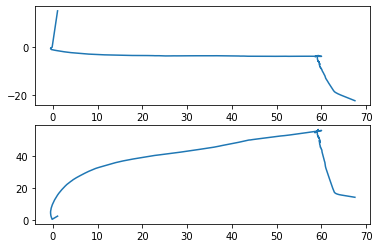

In [14]:
# 3d trajectory
trajectory = get_trajectory_from_poses(poses, K)

# x - y
plt.subplot(211)
plt.plot(trajectory[:, 0], trajectory[:, 1])
# x - z
plt.subplot(212)
plt.plot(trajectory[:, 0], trajectory[:, 2])
plt.show()

In [15]:
# get projected trajectory on the ref image
start_frame = 900
end_frame = start_frame + 200
projected_trajectory = get_reprojected_trajectory_from_poses(poses[start_frame:end_frame], K, camera_offset=np.array([[0.0], [0.4], [0.]]))

In [16]:
len(poses)

1299

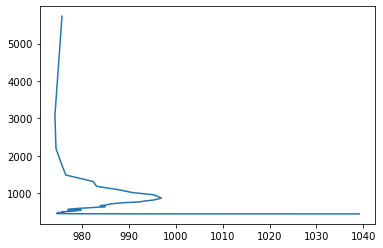

In [17]:
plt.plot(projected_trajectory[:, 0], projected_trajectory[:, 1])

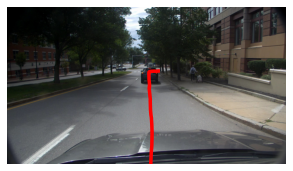

In [18]:
# show the next 10s (trajectory) of the first frame
export_or_visualize_projected_frame(start_frame, frames[start_frame], projected_trajectory)

In [19]:
# the main loop to generate the reprojected frames and export them
# this cell exports the frames 
# and then (manully in terminal)
# (i)  change directory to the specified folder
# (ii) executes $ffmpeg -i frame_%04d.png -vf "fps=[frams-per-second]" [video-name-to-generate].mp4

export_directory = "twophases-short-demo-portland-41.mp4"
        
# check export directory
if os.path.isdir(export_directory):

    # if something exists => delete
    shutil.rmtree(export_directory)

os.makedirs(export_directory)

for i_frame in tqdm(range(len(frames) - int(fps))):
    
    # get the next 10 seconds
    end_frame = i_frame + 10 * int(fps)
    
    projected_trajectory = get_reprojected_trajectory_from_poses(poses[i_frame:end_frame].copy(), 
                                                                 K, 
                                                                 camera_offset=np.array([[0.], [0.4], [0.]]))
    
    export_or_visualize_projected_frame(i_frame, frames[i_frame], 
                                        projected_trajectory, 
                                        export=True, 
                                        export_directory=export_directory)
    